In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.preprocessing.image import ImageDataGenerator
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

In [4]:
#train_files = []
#mask_files = glob('/home/gxt/study/BrainSegmentation/BrainMRI/dataset/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

#for i in mask_files:
    #train_files.append(i.replace('_mask',''))

#print(train_files[:10])
#print(mask_files[:10])
#print(len(train_files))
#print(len(mask_files))
train_files = []
mask_files = []
train = glob('./Doctor-label/Imgs/*.jpg')
mask = glob('./Doctor-label/GT/*.png')
for i in train:
    train_files.append(i)
for i in mask:
    mask_files.append(i)
print(len(train_files))
print(len(mask_files))

98
98


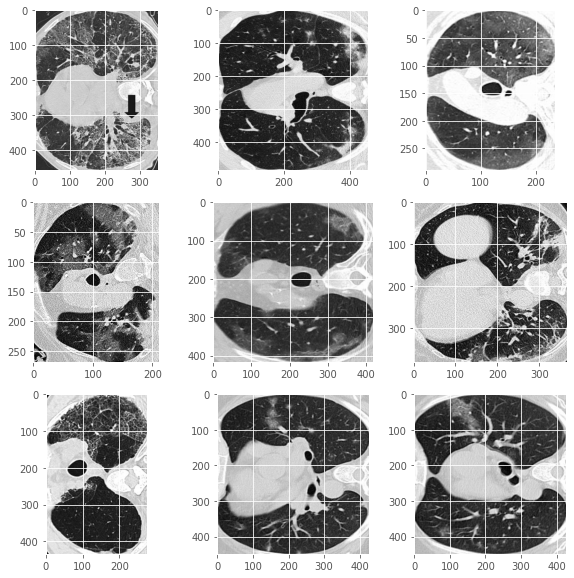

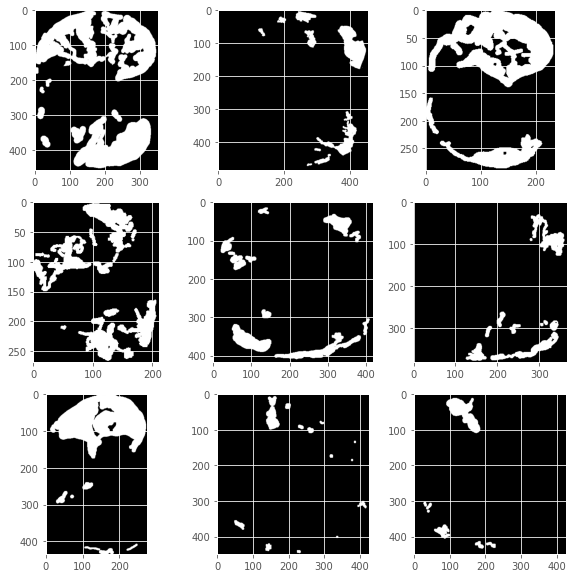

In [5]:
#Lets plot some samples
rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    #msk_path=mask_files[i]
    img=cv2.imread(img_path)
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #msk=cv2.imread(msk_path)
    plt.imshow(img)
    #plt.imshow(msk,alpha=0.4)
    #plt.imshow(msk)
plt.show()
row,col=3,3
fig1=plt.figure(figsize=(10,10))
for i in range(1,row*col+1):
    fig1.add_subplot(row,col,i)
    #img_path=train_files[i]
    msk_path=mask_files[i]
    #img=cv2.imread(img_path)
    #img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    #plt.imshow(img)
    #plt.imshow(msk,alpha=0.4)
    plt.imshow(msk)
plt.show()

In [6]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(70, 2)
(18, 2)
(10, 2)


In [7]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict) 
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [8]:
smooth=100
def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [9]:
def conv_block(inputs, 
            neuron_num, 
            kernel_size,  
            use_bias, 
            padding= 'same',
            strides= (1, 1),
            with_conv_short_cut = False):
        conv1 = Conv2D(
            neuron_num,
            kernel_size = kernel_size,
            activation= 'relu',
            strides= strides,
            use_bias= use_bias,
            padding= padding
        )(inputs)
        conv1 = BatchNormalization(axis = 1)(conv1)

        conv2 = Conv2D(
            neuron_num,
            kernel_size= kernel_size,
            activation= 'relu',
            use_bias= use_bias,
            padding= padding)(conv1)
        conv2 = BatchNormalization(axis = 1)(conv2)

        if with_conv_short_cut:
            inputs = Conv2D(
                neuron_num, 
                kernel_size= kernel_size,
                strides= strides,
                use_bias= use_bias,
                padding= padding
                )(inputs)
            return add([inputs, conv2])

        else:
            return add([inputs, conv2])


def unet_res(input_size = (224,224,3)):
    inputs = Input(shape= input_size)
    
    #x = ZeroPadding2D((3, 3))(inputs)
    #x = Input(shape= input_size)
    #print("x=",x.shape)
    # Define the converlutional block 1
    
    x = BatchNormalization(axis=1)(inputs)
    x = ZeroPadding2D(padding=(3, 3))(x)
    x = Conv2D(64, (7, 7), strides=(2, 2),padding='valid')(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation('relu')(x)
    print("x=",x.shape)
    x1 = MaxPooling2D(pool_size=(3,3),strides=(2, 2), padding='same')(x)
    print("x1=",x1.shape)
    
    # Define the converlutional block 2
    x2 = conv_block(x1, neuron_num= 64, kernel_size= (3, 3), use_bias= True)
    x2 = conv_block(x2, neuron_num= 64, kernel_size= (3, 3), use_bias= True)
    x2 = conv_block(x2, neuron_num= 64, kernel_size= (3, 3), use_bias= True)
    print("x2=",x2.shape)

    # Define the converlutional block 3
    x3 = conv_block(x2, neuron_num= 128, kernel_size= (3, 3), use_bias= True, strides= (2, 2), with_conv_short_cut= True)
    x3 = conv_block(x3, neuron_num= 128, kernel_size= (3, 3), use_bias= True)
    x3 = conv_block(x3, neuron_num= 128, kernel_size= (3, 3), use_bias= True)
    x3 = conv_block(x3, neuron_num= 128, kernel_size= (3, 3), use_bias= True)
    print("x3=",x3.shape)
    
    # Define the converlutional block 4
    x4 = conv_block(x3, neuron_num= 256, kernel_size= (3, 3), use_bias= True, strides= (2, 2), with_conv_short_cut= True)
    x4 = conv_block(x4, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
    x4 = conv_block(x4, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
    x4 = conv_block(x4, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
    x4 = conv_block(x4, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
    x4 = conv_block(x4, neuron_num= 256, kernel_size= (3, 3), use_bias= True)
    print("x4=",x4.shape)
    
    # Define the converltional block 5
    x5 = conv_block(x4, neuron_num= 512, kernel_size= (3, 3), use_bias= True, strides= (2, 2), with_conv_short_cut= True)
    x5 = conv_block(x5, neuron_num= 512, kernel_size= (3, 3), use_bias= True)
    x5 = conv_block(x5, neuron_num= 512, kernel_size= (3, 3), use_bias= True)
    print("x5=",x5.shape)
    #Define upsample
    up6 = Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(x5)
    print("up6=",up6.shape)
    #up6 = Conv2D(256, 2, activation='relu', padding = 'same')(UpSampling2D(size=(2,2))(x5))
    merge6 = concatenate([x4,up6],axis = 3)
    print("merge6=[x4,up6]",merge6.shape)
    conv6 = Conv2D(256,3,activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256,3,activation='relu', padding='same')(conv6)
    print("conv6=",conv6.shape)
    
    up7 = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(conv6)
    print("up7=",up7.shape)
    #up7 = Conv2D(128, 2, activation='relu', padding = 'same')(UpSampling2D(size=(2,2))(conv6))
    merge7 = concatenate([x3,up7],axis = 3)
    print("merge7=[x3,up7]",merge7.shape)
    conv7 = Conv2D(128,3,activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128,3,activation='relu', padding='same')(conv7)
    print("conv7=",conv7.shape)
    
    up8 = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv7)
    print("up8=",up8.shape)
    #up8 = Conv2D(64, 2, activation='relu', padding = 'same')(UpSampling2D(size=(2,2))(conv7))
    merge8 = concatenate([x2,up8],axis = 3)
    print("merge8=[x2,up8]",merge8.shape)
    conv8 = Conv2D(64,3,activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64,3,activation='relu', padding='same')(conv8)
    print("conv8=",conv8.shape)
    
    up9 =  Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv8)
    print("up9=",up9.shape)
    merge9 = concatenate([x,up9],axis = 3)
    print("merge9=[x,up9]",merge9.shape)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)
    print("conv9", conv9.shape)
    conv10 = Conv2D(2, 3, activation='relu', padding='same')(conv9)
    print("conv10", conv10.shape)
    up10 =  Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv9)
    print("up10=",up10.shape)
    conv10 = Conv2D(16, 3, activation='relu', padding='same')(up10)
    conv10 = Conv2D(16, 3, activation='relu', padding='same')(conv10)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv10)
    print("conv10", conv10.shape)
    model = Model(inputs=inputs, outputs=conv10)
    return model

In [10]:
model = unet_res()
#model.summary()
#plot_model(model, to_file='./model2.png', show_shapes=True)

x= (None, 112, 112, 64)
x1= (None, 56, 56, 64)
x2= (None, 56, 56, 64)
x3= (None, 28, 28, 128)
x4= (None, 14, 14, 256)
x5= (None, 7, 7, 512)
up6= (None, 14, 14, 256)
merge6=[x4,up6] (None, 14, 14, 512)
conv6= (None, 14, 14, 256)
up7= (None, 28, 28, 128)
merge7=[x3,up7] (None, 28, 28, 256)
conv7= (None, 28, 28, 128)
up8= (None, 56, 56, 64)
merge8=[x2,up8] (None, 56, 56, 128)
conv8= (None, 56, 56, 64)
up9= (None, 112, 112, 64)
merge9=[x,up9] (None, 112, 112, 128)
conv9 (None, 112, 112, 32)
conv10 (None, 112, 112, 2)
up10= (None, 224, 224, 64)
conv10 (None, 224, 224, 1)


In [11]:
#Set Parameters
im_width = 224
im_height = 224

In [12]:
EPOCHS = 50
BATCH_SIZE = 1
learning_rate = 1e-4

In [13]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet_res(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay= decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef,'AUC'])
#model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', verbose=1, save_best_only=True)
#history = model.fit_generator(train_gen,
#                    steps_per_epoch=100, 
#                    epochs=EPOCHS, 
#                    callbacks= [model_checkpoint],
#                    validation_data = test_gener,
#                    validation_steps=100)
history = model.fit(train_gen,
                    steps_per_epoch=50, 
                    epochs=EPOCHS, 
                    callbacks= [model_checkpoint],
                    validation_data = test_gener,
                    validation_steps=50)

x= (None, 112, 112, 64)
x1= (None, 56, 56, 64)
x2= (None, 56, 56, 64)
x3= (None, 28, 28, 128)
x4= (None, 14, 14, 256)
x5= (None, 7, 7, 512)
up6= (None, 14, 14, 256)
merge6=[x4,up6] (None, 14, 14, 512)
conv6= (None, 14, 14, 256)
up7= (None, 28, 28, 128)
merge7=[x3,up7] (None, 28, 28, 256)
conv7= (None, 28, 28, 128)
up8= (None, 56, 56, 64)
merge8=[x2,up8] (None, 56, 56, 128)
conv8= (None, 56, 56, 64)
up9= (None, 112, 112, 64)
merge9=[x,up9] (None, 112, 112, 128)
conv9 (None, 112, 112, 32)
conv10 (None, 112, 112, 2)
up10= (None, 224, 224, 64)
conv10 (None, 224, 224, 1)
Found 70 validated image filenames.
Found 70 validated image filenames.
Epoch 1/50
50/50 [==============================] - ETA: 0s - loss: -0.2164 - binary_accuracy: 0.3966 - iou: 0.1294 - dice_coef: 0.2164 - auc: 0.5430Found 18 validated image filenames.
Found 18 validated image filenames.
50/50 [==============================] - 14s 120ms/step - loss: -0.2170 - binary_accuracy: 0.3947 - iou: 0.1298 - dice_coef: 0.2170 - 


Epoch 00022: val_loss improved from -0.55952 to -0.58631, saving model to unet_membrane.hdf5
Epoch 23/50
50/50 [==============================] - 9s 189ms/step - loss: -0.6710 - binary_accuracy: 0.9027 - iou: 0.5214 - dice_coef: 0.6710 - auc: 0.8473 - val_loss: -0.5728 - val_binary_accuracy: 0.9148 - val_iou: 0.4347 - val_dice_coef: 0.5728 - val_auc: 0.8271

Epoch 00023: val_loss did not improve from -0.58631
Epoch 24/50
50/50 [==============================] - 10s 197ms/step - loss: -0.5779 - binary_accuracy: 0.8855 - iou: 0.4246 - dice_coef: 0.5779 - auc: 0.7685 - val_loss: -0.5391 - val_binary_accuracy: 0.9243 - val_iou: 0.4011 - val_dice_coef: 0.5391 - val_auc: 0.7853

Epoch 00024: val_loss did not improve from -0.58631
Epoch 25/50
50/50 [==============================] - 11s 218ms/step - loss: -0.6903 - binary_accuracy: 0.9138 - iou: 0.5448 - dice_coef: 0.6903 - auc: 0.8607 - val_loss: -0.5717 - val_binary_accuracy: 0.9332 - val_iou: 0.4323 - val_dice_coef: 0.5717 - val_auc: 0.80

In [14]:
model.save('./model/unet_Lung_CT_seg.h5')

In [15]:
model = load_model('./model/unet_Lung_CT_seg.h5',custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
model = load_model('unet_Lung_CT_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [17]:
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef,'AUC'])
test_gen = train_generator(df_test, BATCH_SIZE,
                           dict(),
                                target_size=(im_height, im_width))
print(len(df_test))

results = model.evaluate(x=test_gen,batch_size=BATCH_SIZE, steps=len(df_test)/BATCH_SIZE)
#results = model.predict(x=test_gen,batch_size=BATCH_SIZE, steps=len(df_test)/BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])
print("Test_auc:",results[3]*100,"%")

10
Found 10 validated image filenames.
Found 10 validated image filenames.
10/10 [==============================] - 4s 139ms/step - loss: -0.5487 - binary_accuracy: 0.8637 - iou: 0.4106 - dice_coef: 0.5487 - auc: 0.7259
Test lost:  -0.5283718109130859
Test IOU:  0.853128969669342
Test Dice Coefficent:  0.39413759112358093
Test_auc: 52.837181091308594 %


In [18]:
train_auc = history.history['auc'][49]
test_auc = results[3]
train_mAP = train_auc/2
test_mAP = test_auc/2
print("train_mAP:",train_mAP*100,"%")
print("test_mAP:",test_mAP*100,"%")

train_mAP: 43.30945611000061 %
test_mAP: 26.418590545654297 %


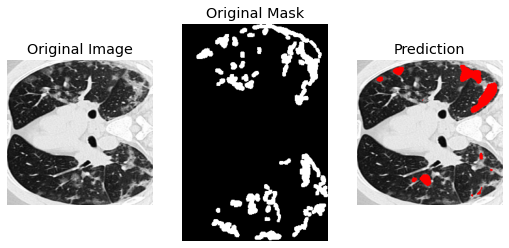

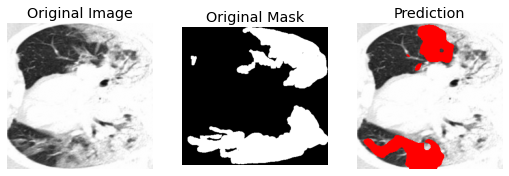

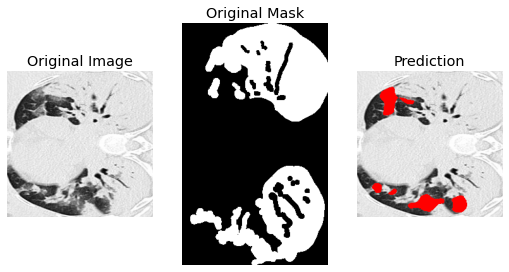

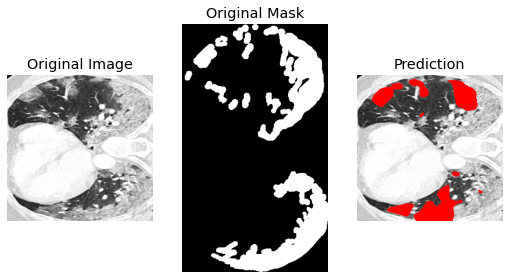

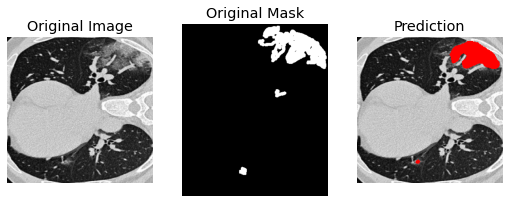

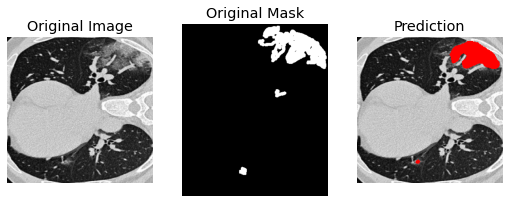

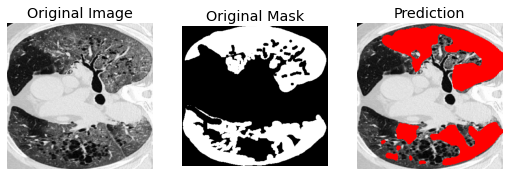

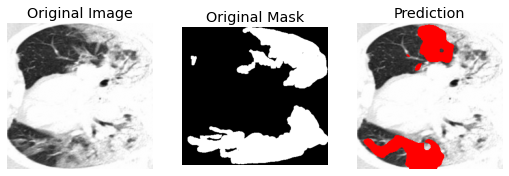

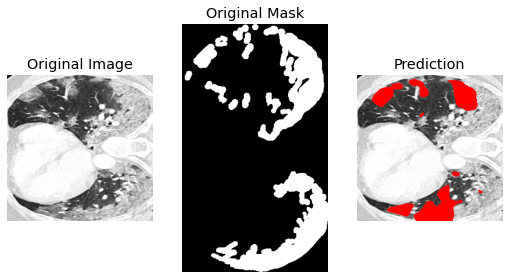

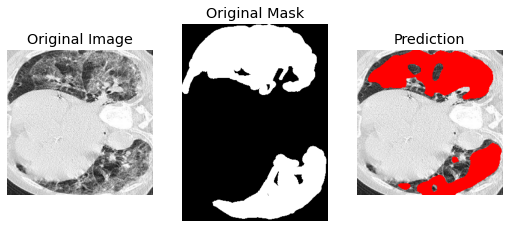

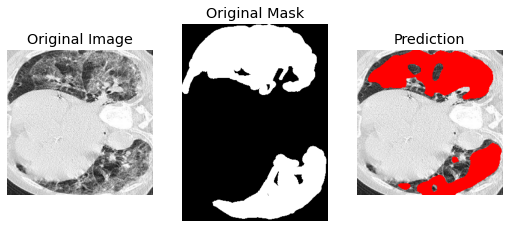

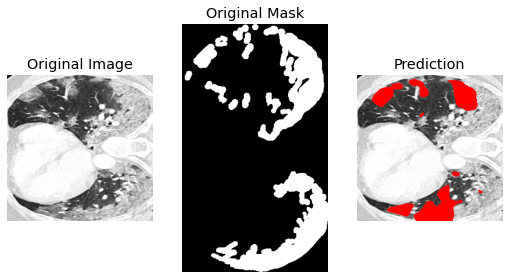

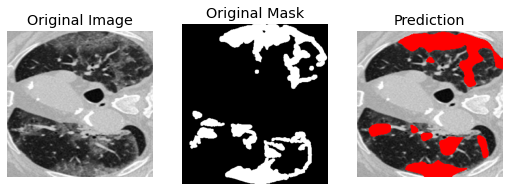

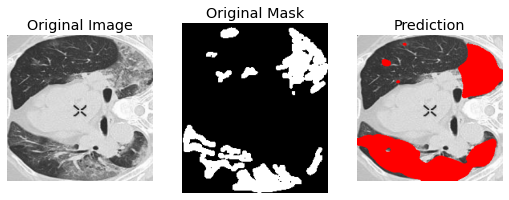

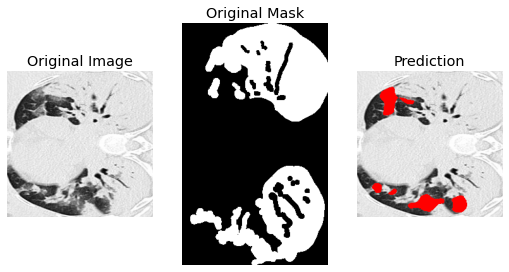

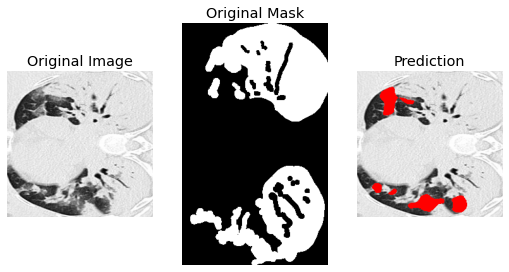

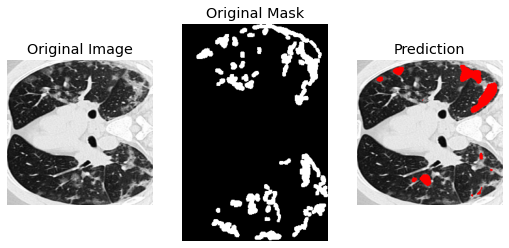

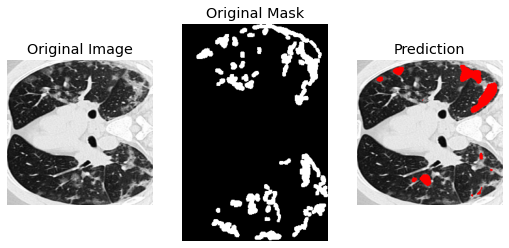

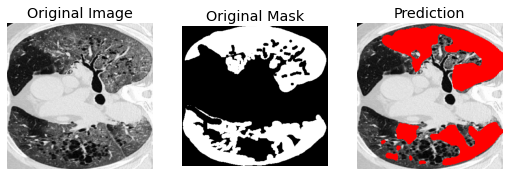

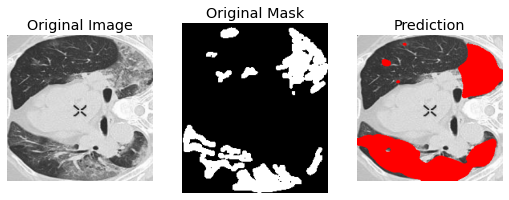

In [19]:
for i in range(20):
    path = "./pred/Res-Unet/"
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
         #print(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,4,1)
         #print(path+df_test['filename'].iloc[index])
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1,4,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.axis('off')
    plt.title('Original Mask')
    img=np.squeeze(img)
    img[np.squeeze(pred) > .6]=(1,0,0)
    plt.subplot(1,4,3)
    #plt.imshow(np.squeeze(pred) > .6)
    #plt.title('Prediction')
             #plt.subplot(1,4,4)
             #plt.title('cover')
             #squeeze  =np.squeeze(pred) > .6
             #dst = cv2.addWeighted(img1,1,img2,0.7,0) 
    #plt.show()
    plt.imshow(np.squeeze(img))
    plt.axis('off')
    plt.title('Prediction')
    plt.savefig(path+str(i)+".png")
    #cv2.imwrite(path+str(i)+".png", np.squeeze(img))
    plt.show()

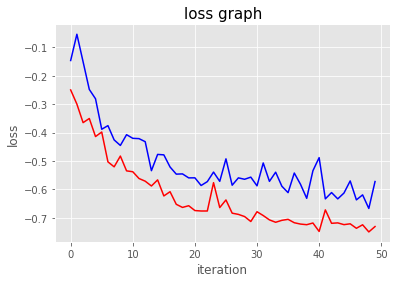

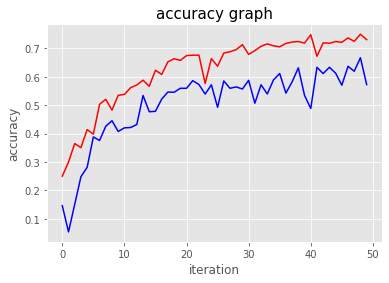

In [20]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()